In [1]:
import torch
import numpy as np
import cv2
import tensorflow as tf
from modelos.keypoint import KeypointDetectorModel
from common.homography import visualize, _points_from_mask, denormalize
from common.translation import get_players, draw_template
from matplotlib import pyplot as plt

C:\Users\itzca\.pyenv\pyenv-win\versions\3.7.9\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [2]:
def get_image(path):
    image = cv2.imread(path)
    image = cv2.resize(image, (1024, 1024))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def get_template():
    template = cv2.imread('media/template.png')
    template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)
    template = cv2.resize(template, (1280,720))/255.
    template_copy = template
    return template_copy

In [3]:
def load_keypoint():
    kp_model = KeypointDetectorModel(backbone='efficientnetb3', num_classes=29, input_shape=(512, 512),)
    WEIGHTS_PATH = ("models/keypoint_detector.h5")
    WEIGHTS_NAME = "keypoint_detector.h5"
    WEIGHTS_TOTAR = False
    checkpoints = tf.keras.utils.get_file(WEIGHTS_NAME, WEIGHTS_PATH, WEIGHTS_TOTAR,)
    kp_model.load_weights(checkpoints)
    return kp_model

In [4]:
def get_players2(results, image):
    coord = results.xyxy[0]
    detecciones = coord.size(dim=0)
    puntos = []
    players = []
    for obj in range(0, detecciones):
        x1 = int(coord[obj][0].item())
        y1 = int(coord[obj][1].item())
        x2 = int(coord[obj][2].item()) 
        y2 = int(coord[obj][3].item())
        puntos.append([int(((x1 + x2)/2)), y2])
        player = image[y1:y2, x1:x2]
        players.append(player)
    return puntos, players

In [5]:
def get_matrix(kp_model, imagen):
    pr_mask = kp_model(imagen)
    visualize(image=denormalize(imagen.squeeze()),pr_mask=pr_mask[..., -1].squeeze(),)
    src,dst = _points_from_mask(pr_mask[0])
    M, _ = cv2.findHomography(src, dst, cv2.RANSAC, 5)
    return M

def show_template(model, template, Matrix, img):
    detecciones = model(img)
    puntos, players = get_players2(detecciones, img)
    temp = draw_template(cv2.resize(template, (320, 320)), puntos, Matrix)
    return temp, players

In [6]:
yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s')
template = get_template()
kp_model = load_keypoint()

Using cache found in C:\Users\itzca/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-11-1 Python-3.7.9 torch-1.13.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


Succesfully loaded weights from C:\Users\itzca\.keras\datasets\keypoint_detector.h5


C:\Users\itzca\OneDrive\Documents\Tracker\common\homography.py:47: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


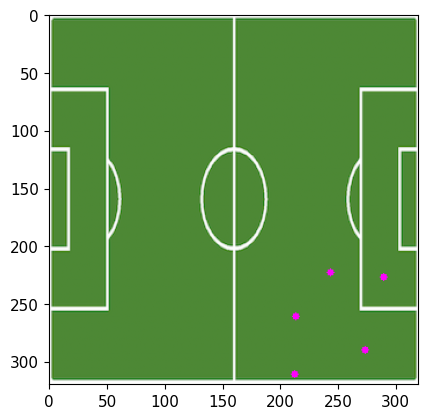

In [7]:
image = get_image('media/cap.jpg')
#image = get_image('media/cap.png')

M = get_matrix(kp_model, image)
template_2d, players = show_template(yolo, template, M, image)
#template_2d = cv2.resize(template_2d, (1024, 1024))
%matplotlib inline 
plt.imshow(template_2d)
plt.show()

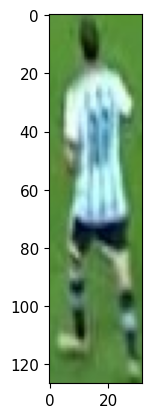

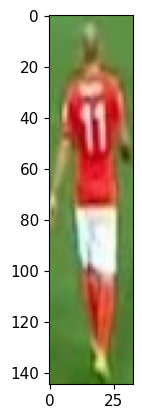

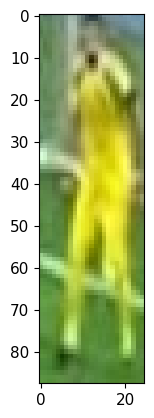

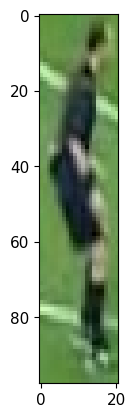

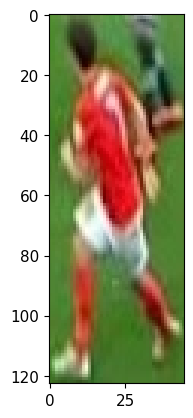

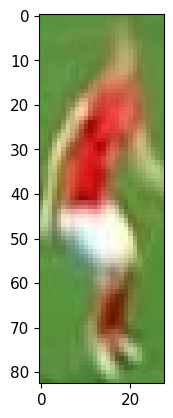

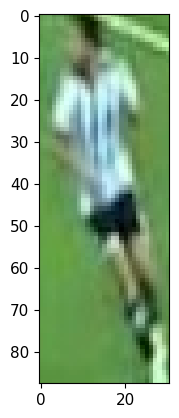

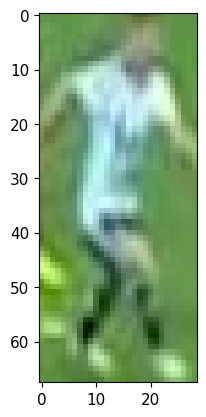

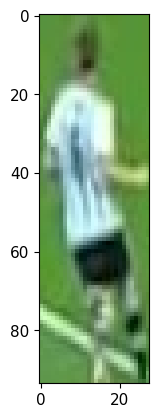

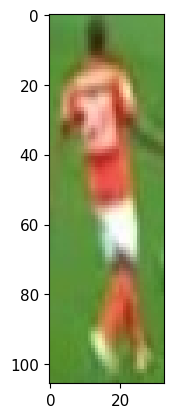

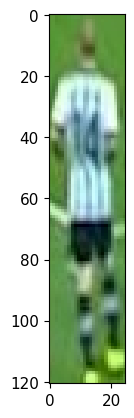

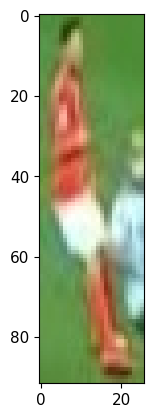

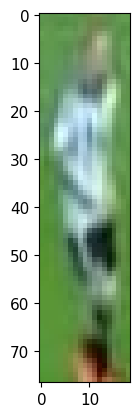

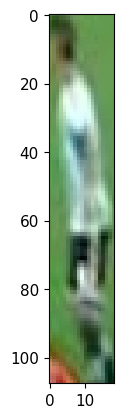

In [23]:
i = 0
for player in players:
    plt.imshow(player)
    plt.show()
    cv2.imwrite("{}.jpg".format(i), player)
    i += 1

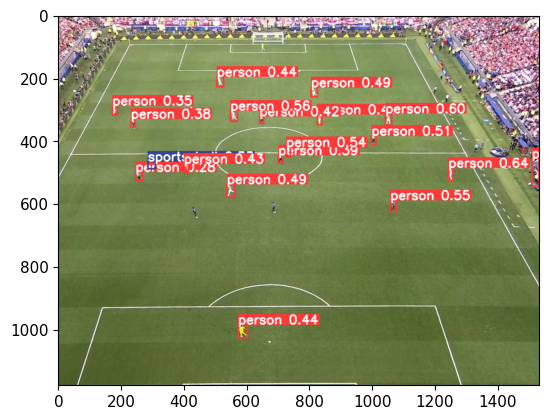

In [12]:
image = cv2.imread('media/cap1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
detecciones = yolo(image)
plt.imshow(np.squeeze(detecciones.render()))
plt.show()